# IMPORT STATMENTS FOR ALL MODLES

In [1]:
!TMPDIR=/home/mgill/ pip install --cache-dir=/home/mgill/ --build /home/mgill/ pandas numpy sklearn xgboost matplotlib tensorflow==2.1.0 keras==2.2.4 fastai python-dateutil scikit-optimize scikit-learn==0.21 seaborn

Defaulting to user installation because normal site-packages is not writeable


You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [2]:
import tensorflow as tf; print(tf.__version__)
import keras; print(keras.__version__)
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from keras.regularizers import *
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from fastai.tabular.all import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from random import randint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing import sequence
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Activation
from math import sqrt
from statistics import mean
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt 
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.impute import SimpleImputer
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV
from keras.optimizers import Adam
import skopt
from skopt.searchcv import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.model_selection import GridSearchCV
import pickle
from collections import OrderedDict
from sklearn.model_selection import StratifiedKFold
from scipy import interp
import seaborn as sns
sns.set()
sns.set_style('whitegrid')

2.1.0


Using TensorFlow backend.


2.2.4


/home/mgill/.local/lib/python3.6/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [3]:
def new_prep_data(tt_file, ho_file):
    imp = SimpleImputer(missing_values='./.', strategy='most_frequent')
    my_list = []
    x = 0 
    for chunk in pd.read_csv(tt_file, chunksize=10000, index_col="Unnamed: 0"):
        x=x+10000
        chunk = chunk.T
        if 'Value' in chunk.columns:
            #does the selecting of pheno array for application ML
            chunk["Value"] = pd.to_numeric(chunk["Value"], downcast="float")
            tt_pheno = chunk["Value"].to_numpy()
            #reshapes it so its not a 1D array
            print(tt_pheno.shape)
            tt_pheno = np.reshape(tt_pheno,(len(tt_pheno),1))
            print(tt_pheno.shape)
            chunk = chunk.drop(columns=['Value'])
        headers = chunk.columns
        row_idx = chunk.index
        chunk = imp.fit_transform(chunk) #SHOULD TURN ./. into the most common for each column
        #since imputing makes a numpy array have to turn back into PD for label encoding
        chunk = pd.DataFrame(data = chunk, index = row_idx, columns = headers)
        my_list.append(chunk)
        print(x)
    tt_vcf = pd.concat(my_list, axis = 1)
    my_list = []
    x=0
    for chunk in pd.read_csv(ho_file, chunksize=10000, index_col="Unnamed: 0"):
        x=x+10000
        chunk = chunk.T
        if 'Value' in chunk.columns:
            #does the selecting of pheno array for application ML
            chunk["Value"] = pd.to_numeric(chunk["Value"], downcast="float")
            ho_pheno = chunk["Value"].to_numpy()
            #reshapes it so its not a 1D array
            print(ho_pheno.shape)
            ho_pheno = np.reshape(ho_pheno,(len(ho_pheno),1))
            print(ho_pheno.shape)
            chunk = chunk.drop(columns=['Value'])
        headers = chunk.columns
        row_idx = chunk.index
        chunk = imp.fit_transform(chunk) #SHOULD TURN ./. into the most common for each column
        #since imputing makes a numpy array have to turn back into PD for label encoding
        chunk = pd.DataFrame(data = chunk, index = row_idx, columns = headers)
        my_list.append(chunk)
        print(x)
    ho_vcf = pd.concat(my_list, axis = 1)
    print(tt_vcf.shape)
    print(ho_vcf.shape)
    return tt_vcf, ho_vcf, tt_pheno, ho_pheno

In [4]:
tt_vcf, ho_vcf, tt_pheno, ho_pheno = new_prep_data("Oil_Merged_filtered.csv_train_testQTL_SNPS.csv", "Oil_Merged_filtered.csv_holdoutQTL_SNPS.csv")

10000
20000
30000
40000
(753,)
(753, 1)
50000
10000
20000
30000
40000
(189,)
(189, 1)
50000
(753, 40448)
(189, 40448)


In [5]:
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
ohe = ohe.fit(tt_vcf)
print(tt_vcf.shape)
tt_vcf = ohe.transform(tt_vcf)
print(tt_vcf.shape)
print(ho_vcf.shape)
ho_vcf = ohe.transform(ho_vcf)
print(ho_vcf.shape)

(753, 40448)
(753, 117552)
(189, 40448)
(189, 117552)


In [6]:
pickle.dump(ohe, open("Oil_QTL_ohe.dat", "wb"))

In [7]:
#if need or have new holdout data etc.
ohe = pickle.load(open("Oil_QTL_ohe.dat", "rb"))

In [8]:
def find_snp_from_header(ohe,snp_num):
    count = 0
    snp = "Not found"
    found = False
    i = 0
    while i < len(ohe.categories_) and (found == False):
        j = 0
        while j < len(ohe.categories_[i]):
            if(count == snp_num):
                snp = ohe.categories_[i][j]
                found = True
                break
            count = count + 1
            j = j + 1
        i = i + 1
    return snp

In [9]:
## TESTING IF IT WORKS
my_snp = find_snp_from_header(ohe, 108005)
print(my_snp)

A/A


# XGBoost ML Model

In [10]:
print(tt_vcf.shape)
print(tt_pheno.shape)
seed = randint(0,5000)
X_train, X_test, y_train, y_test = train_test_split(tt_vcf, tt_pheno, test_size=0.2, random_state=seed)
print(X_test.shape)
print("seed is " + str(seed))

(753, 117552)
(753, 1)
(151, 117552)
seed is 3798


In [11]:
space ={'learning_rate': Real(0.01, 1.0, 'log-uniform'),
        'min_child_weight': Integer(0, 10),
        'max_depth': Integer(0, 50),
        'max_delta_step': Integer(0, 20),
        'subsample': Real(0.01, 1.0, 'uniform'),
        'colsample_bytree': Real(0.01, 1.0, 'uniform'),
        'colsample_bylevel': Real(0.01, 1.0, 'uniform'),
        'reg_lambda': Real(1e-9, 1000, 'log-uniform'),
        'reg_alpha': Real(1e-9, 1.0, 'log-uniform'),
        'gamma': Real(1e-9, 0.5, 'log-uniform'),
        'min_child_weight': Integer(0, 5),
        'n_estimators': Integer(50, 200),
        'scale_pos_weight': Real(1e-6, 500, 'log-uniform')}


In [12]:
def on_step(optim_result):
    """
    Callback meant to view scores after
    each iteration while performing Bayesian
    Optimization in Skopt"""
    score = xgb_bayes_search.best_score_
    print("best score: %s" % score)
    if score >= 0.98:
        print('Interrupting!')
        return True

In [13]:
xgbreg = xgb.XGBRegressor()
xgb_bayes_search = BayesSearchCV(xgbreg, space, n_iter=32, # specify how many iterations
                                    scoring=None, n_jobs=1, cv=5, verbose=3, random_state=42, n_points=12,
                                 refit=True)
xgb_bayes_search.fit(X_train, y_train.ravel(), callback = on_step)
print(xgb_bayes_search.best_params_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] colsample_bylevel=0.4160029192647807, colsample_bytree=0.7304484857455519, gamma=0.13031389926541354, learning_rate=0.042815319280763466, max_delta_step=13, max_depth=21, min_child_weight=2, n_estimators=161, reg_alpha=5.497557739289786e-07, reg_lambda=0.05936070635912049, scale_pos_weight=0.060830282487222144, subsample=0.13556548021189216 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  colsample_bylevel=0.4160029192647807, colsample_bytree=0.7304484857455519, gamma=0.13031389926541354, learning_rate=0.042815319280763466, max_delta_step=13, max_depth=21, min_child_weight=2, n_estimators=161, reg_alpha=5.497557739289786e-07, reg_lambda=0.05936070635912049, scale_pos_weight=0.060830282487222144, subsample=0.13556548021189216, score=0.753, total=  24.4s
[CV] colsample_bylevel=0.4160029192647807, colsample_bytree=0.7304484857455519, gamma=0.13031389926541354, learning_rate=0.042815319280763466, max_delta_step=13, max_depth=21, min_child_weight=2, n_estimators=161, reg_alpha=5.497557739289786e-07, reg_lambda=0.05936070635912049, scale_pos_weight=0.060830282487222144, subsample=0.13556548021189216 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   24.4s remaining:    0.0s


[CV]  colsample_bylevel=0.4160029192647807, colsample_bytree=0.7304484857455519, gamma=0.13031389926541354, learning_rate=0.042815319280763466, max_delta_step=13, max_depth=21, min_child_weight=2, n_estimators=161, reg_alpha=5.497557739289786e-07, reg_lambda=0.05936070635912049, scale_pos_weight=0.060830282487222144, subsample=0.13556548021189216, score=0.672, total=  23.6s
[CV] colsample_bylevel=0.4160029192647807, colsample_bytree=0.7304484857455519, gamma=0.13031389926541354, learning_rate=0.042815319280763466, max_delta_step=13, max_depth=21, min_child_weight=2, n_estimators=161, reg_alpha=5.497557739289786e-07, reg_lambda=0.05936070635912049, scale_pos_weight=0.060830282487222144, subsample=0.13556548021189216 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   48.0s remaining:    0.0s


[CV]  colsample_bylevel=0.4160029192647807, colsample_bytree=0.7304484857455519, gamma=0.13031389926541354, learning_rate=0.042815319280763466, max_delta_step=13, max_depth=21, min_child_weight=2, n_estimators=161, reg_alpha=5.497557739289786e-07, reg_lambda=0.05936070635912049, scale_pos_weight=0.060830282487222144, subsample=0.13556548021189216, score=0.654, total=  24.2s
[CV] colsample_bylevel=0.4160029192647807, colsample_bytree=0.7304484857455519, gamma=0.13031389926541354, learning_rate=0.042815319280763466, max_delta_step=13, max_depth=21, min_child_weight=2, n_estimators=161, reg_alpha=5.497557739289786e-07, reg_lambda=0.05936070635912049, scale_pos_weight=0.060830282487222144, subsample=0.13556548021189216 
[CV]  colsample_bylevel=0.4160029192647807, colsample_bytree=0.7304484857455519, gamma=0.13031389926541354, learning_rate=0.042815319280763466, max_delta_step=13, max_depth=21, min_child_weight=2, n_estimators=161, reg_alpha=5.497557739289786e-07, reg_lambda=0.0593607063591

[CV]  colsample_bylevel=0.25617325301227906, colsample_bytree=0.7083937150495909, gamma=2.41812432168581e-07, learning_rate=0.13965555720269418, max_delta_step=10, max_depth=27, min_child_weight=1, n_estimators=76, reg_alpha=3.178148842971562e-08, reg_lambda=0.005381781269387993, scale_pos_weight=0.23835043249575294, subsample=0.9559763235078597, score=0.562, total=  15.6s
[CV] colsample_bylevel=0.7711308526006485, colsample_bytree=0.07988300914246868, gamma=1.3877597085692663e-08, learning_rate=0.15021004353467043, max_delta_step=6, max_depth=3, min_child_weight=3, n_estimators=77, reg_alpha=0.006097622112520179, reg_lambda=1.9368851099909265e-09, scale_pos_weight=6.97020795804701e-06, subsample=0.46717487628832827 
[CV]  colsample_bylevel=0.7711308526006485, colsample_bytree=0.07988300914246868, gamma=1.3877597085692663e-08, learning_rate=0.15021004353467043, max_delta_step=6, max_depth=3, min_child_weight=3, n_estimators=77, reg_alpha=0.006097622112520179, reg_lambda=1.9368851099909

[CV]  colsample_bylevel=0.3569079180734289, colsample_bytree=0.1120289995668169, gamma=0.05034432042804318, learning_rate=0.7467518194835729, max_delta_step=7, max_depth=47, min_child_weight=1, n_estimators=67, reg_alpha=0.005500281359785164, reg_lambda=6.3166999939833564e-06, scale_pos_weight=0.4420166988445819, subsample=0.037978567417966985, score=-39.089, total=   7.6s
[CV] colsample_bylevel=0.3569079180734289, colsample_bytree=0.1120289995668169, gamma=0.05034432042804318, learning_rate=0.7467518194835729, max_delta_step=7, max_depth=47, min_child_weight=1, n_estimators=67, reg_alpha=0.005500281359785164, reg_lambda=6.3166999939833564e-06, scale_pos_weight=0.4420166988445819, subsample=0.037978567417966985 
[CV]  colsample_bylevel=0.3569079180734289, colsample_bytree=0.1120289995668169, gamma=0.05034432042804318, learning_rate=0.7467518194835729, max_delta_step=7, max_depth=47, min_child_weight=1, n_estimators=67, reg_alpha=0.005500281359785164, reg_lambda=6.3166999939833564e-06, 

[CV]  colsample_bylevel=0.19358622710388942, colsample_bytree=0.9236239290551462, gamma=6.242737149649543e-09, learning_rate=0.5839290998374393, max_delta_step=9, max_depth=2, min_child_weight=1, n_estimators=157, reg_alpha=0.32247446903004606, reg_lambda=5.7439751766594195e-06, scale_pos_weight=1.6287615199535114e-06, subsample=0.9872483677632868, score=0.695, total=  16.1s
[CV] colsample_bylevel=0.19358622710388942, colsample_bytree=0.9236239290551462, gamma=6.242737149649543e-09, learning_rate=0.5839290998374393, max_delta_step=9, max_depth=2, min_child_weight=1, n_estimators=157, reg_alpha=0.32247446903004606, reg_lambda=5.7439751766594195e-06, scale_pos_weight=1.6287615199535114e-06, subsample=0.9872483677632868 
[CV]  colsample_bylevel=0.19358622710388942, colsample_bytree=0.9236239290551462, gamma=6.242737149649543e-09, learning_rate=0.5839290998374393, max_delta_step=9, max_depth=2, min_child_weight=1, n_estimators=157, reg_alpha=0.32247446903004606, reg_lambda=5.74397517665941

[CV]  colsample_bylevel=0.8477171831834894, colsample_bytree=0.9590782028716157, gamma=0.4419705200245942, learning_rate=0.010068534554171981, max_delta_step=18, max_depth=46, min_child_weight=5, n_estimators=66, reg_alpha=1.3396471230171212e-09, reg_lambda=0.1502689667792386, scale_pos_weight=5.68219069233494e-06, subsample=0.3682037565911086, score=-6.207, total=  15.1s
[CV] colsample_bylevel=0.8477171831834894, colsample_bytree=0.9590782028716157, gamma=0.4419705200245942, learning_rate=0.010068534554171981, max_delta_step=18, max_depth=46, min_child_weight=5, n_estimators=66, reg_alpha=1.3396471230171212e-09, reg_lambda=0.1502689667792386, scale_pos_weight=5.68219069233494e-06, subsample=0.3682037565911086 
[CV]  colsample_bylevel=0.8477171831834894, colsample_bytree=0.9590782028716157, gamma=0.4419705200245942, learning_rate=0.010068534554171981, max_delta_step=18, max_depth=46, min_child_weight=5, n_estimators=66, reg_alpha=1.3396471230171212e-09, reg_lambda=0.1502689667792386, s

[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed: 16.5min finished


best score: 0.6877986529085753
Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] colsample_bylevel=0.8405914889249873, colsample_bytree=0.3262971864092083, gamma=7.33891032782887e-05, learning_rate=0.16458417161965755, max_delta_step=6, max_depth=5, min_child_weight=3, n_estimators=151, reg_alpha=1.3247101238196073e-08, reg_lambda=3.6481484057494464, scale_pos_weight=0.0001638202321731888, subsample=0.7789708476212507 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  colsample_bylevel=0.8405914889249873, colsample_bytree=0.3262971864092083, gamma=7.33891032782887e-05, learning_rate=0.16458417161965755, max_delta_step=6, max_depth=5, min_child_weight=3, n_estimators=151, reg_alpha=1.3247101238196073e-08, reg_lambda=3.6481484057494464, scale_pos_weight=0.0001638202321731888, subsample=0.7789708476212507, score=0.658, total=  17.3s
[CV] colsample_bylevel=0.8405914889249873, colsample_bytree=0.3262971864092083, gamma=7.33891032782887e-05, learning_rate=0.16458417161965755, max_delta_step=6, max_depth=5, min_child_weight=3, n_estimators=151, reg_alpha=1.3247101238196073e-08, reg_lambda=3.6481484057494464, scale_pos_weight=0.0001638202321731888, subsample=0.7789708476212507 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   17.3s remaining:    0.0s


[CV]  colsample_bylevel=0.8405914889249873, colsample_bytree=0.3262971864092083, gamma=7.33891032782887e-05, learning_rate=0.16458417161965755, max_delta_step=6, max_depth=5, min_child_weight=3, n_estimators=151, reg_alpha=1.3247101238196073e-08, reg_lambda=3.6481484057494464, scale_pos_weight=0.0001638202321731888, subsample=0.7789708476212507, score=0.664, total=  16.4s
[CV] colsample_bylevel=0.8405914889249873, colsample_bytree=0.3262971864092083, gamma=7.33891032782887e-05, learning_rate=0.16458417161965755, max_delta_step=6, max_depth=5, min_child_weight=3, n_estimators=151, reg_alpha=1.3247101238196073e-08, reg_lambda=3.6481484057494464, scale_pos_weight=0.0001638202321731888, subsample=0.7789708476212507 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   33.7s remaining:    0.0s


[CV]  colsample_bylevel=0.8405914889249873, colsample_bytree=0.3262971864092083, gamma=7.33891032782887e-05, learning_rate=0.16458417161965755, max_delta_step=6, max_depth=5, min_child_weight=3, n_estimators=151, reg_alpha=1.3247101238196073e-08, reg_lambda=3.6481484057494464, scale_pos_weight=0.0001638202321731888, subsample=0.7789708476212507, score=0.690, total=  17.2s
[CV] colsample_bylevel=0.8405914889249873, colsample_bytree=0.3262971864092083, gamma=7.33891032782887e-05, learning_rate=0.16458417161965755, max_delta_step=6, max_depth=5, min_child_weight=3, n_estimators=151, reg_alpha=1.3247101238196073e-08, reg_lambda=3.6481484057494464, scale_pos_weight=0.0001638202321731888, subsample=0.7789708476212507 
[CV]  colsample_bylevel=0.8405914889249873, colsample_bytree=0.3262971864092083, gamma=7.33891032782887e-05, learning_rate=0.16458417161965755, max_delta_step=6, max_depth=5, min_child_weight=3, n_estimators=151, reg_alpha=1.3247101238196073e-08, reg_lambda=3.6481484057494464, 

[CV]  colsample_bylevel=0.01, colsample_bytree=0.01, gamma=1e-09, learning_rate=1.0, max_delta_step=20, max_depth=34, min_child_weight=0, n_estimators=200, reg_alpha=3.419897065909531e-05, reg_lambda=1e-09, scale_pos_weight=12.61400772716783, subsample=1.0, score=0.466, total=  15.6s
[CV] colsample_bylevel=0.01, colsample_bytree=0.01, gamma=1e-09, learning_rate=1.0, max_delta_step=20, max_depth=34, min_child_weight=0, n_estimators=200, reg_alpha=3.419897065909531e-05, reg_lambda=1e-09, scale_pos_weight=12.61400772716783, subsample=1.0 
[CV]  colsample_bylevel=0.01, colsample_bytree=0.01, gamma=1e-09, learning_rate=1.0, max_delta_step=20, max_depth=34, min_child_weight=0, n_estimators=200, reg_alpha=3.419897065909531e-05, reg_lambda=1e-09, scale_pos_weight=12.61400772716783, subsample=1.0, score=0.331, total=  17.1s
[CV] colsample_bylevel=0.01, colsample_bytree=0.01, gamma=1e-09, learning_rate=1.0, max_delta_step=20, max_depth=34, min_child_weight=0, n_estimators=200, reg_alpha=3.419897

[CV]  colsample_bylevel=0.5800642253107854, colsample_bytree=1.0, gamma=3.621052043067189e-08, learning_rate=0.013961361160496528, max_delta_step=20, max_depth=22, min_child_weight=0, n_estimators=200, reg_alpha=1e-09, reg_lambda=3.708650221386838e-08, scale_pos_weight=1e-06, subsample=0.01, score=0.424, total=  24.2s
[CV] colsample_bylevel=0.5800642253107854, colsample_bytree=1.0, gamma=3.621052043067189e-08, learning_rate=0.013961361160496528, max_delta_step=20, max_depth=22, min_child_weight=0, n_estimators=200, reg_alpha=1e-09, reg_lambda=3.708650221386838e-08, scale_pos_weight=1e-06, subsample=0.01 
[CV]  colsample_bylevel=0.5800642253107854, colsample_bytree=1.0, gamma=3.621052043067189e-08, learning_rate=0.013961361160496528, max_delta_step=20, max_depth=22, min_child_weight=0, n_estimators=200, reg_alpha=1e-09, reg_lambda=3.708650221386838e-08, scale_pos_weight=1e-06, subsample=0.01, score=0.452, total=  22.4s
[CV] colsample_bylevel=0.5800642253107854, colsample_bytree=1.0, gam

[CV]  colsample_bylevel=0.01, colsample_bytree=0.5326328612531414, gamma=1e-09, learning_rate=1.0, max_delta_step=20, max_depth=15, min_child_weight=0, n_estimators=200, reg_alpha=0.0004954624855945318, reg_lambda=1.9918515169495184e-09, scale_pos_weight=499.99999999999994, subsample=1.0, score=0.181, total=  17.7s
[CV] colsample_bylevel=0.01, colsample_bytree=0.01, gamma=0.49999999999999994, learning_rate=0.01, max_delta_step=0, max_depth=0, min_child_weight=5, n_estimators=200, reg_alpha=1e-09, reg_lambda=1e-09, scale_pos_weight=499.99999999999994, subsample=0.01 
[CV]  colsample_bylevel=0.01, colsample_bytree=0.01, gamma=0.49999999999999994, learning_rate=0.01, max_delta_step=0, max_depth=0, min_child_weight=5, n_estimators=200, reg_alpha=1e-09, reg_lambda=1e-09, scale_pos_weight=499.99999999999994, subsample=0.01, score=-2.982, total=  15.2s
[CV] colsample_bylevel=0.01, colsample_bytree=0.01, gamma=0.49999999999999994, learning_rate=0.01, max_delta_step=0, max_depth=0, min_child_we

[CV]  colsample_bylevel=1.0, colsample_bytree=0.21200340458196543, gamma=7.610275097408346e-06, learning_rate=1.0, max_delta_step=8, max_depth=41, min_child_weight=5, n_estimators=72, reg_alpha=1e-09, reg_lambda=1.551541018200927e-05, scale_pos_weight=0.010054113891453427, subsample=1.0, score=0.290, total=  10.1s


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed: 19.0min finished


best score: 0.6941042479586439
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] colsample_bylevel=0.9034143154332803, colsample_bytree=0.07915116274232288, gamma=2.2305036778828498e-09, learning_rate=0.6896481239661728, max_delta_step=10, max_depth=44, min_child_weight=5, n_estimators=200, reg_alpha=2.2208246627181112e-09, reg_lambda=1000.0, scale_pos_weight=0.005772286229924983, subsample=0.3022559074431211 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  colsample_bylevel=0.9034143154332803, colsample_bytree=0.07915116274232288, gamma=2.2305036778828498e-09, learning_rate=0.6896481239661728, max_delta_step=10, max_depth=44, min_child_weight=5, n_estimators=200, reg_alpha=2.2208246627181112e-09, reg_lambda=1000.0, scale_pos_weight=0.005772286229924983, subsample=0.3022559074431211, score=0.744, total=  16.6s
[CV] colsample_bylevel=0.9034143154332803, colsample_bytree=0.07915116274232288, gamma=2.2305036778828498e-09, learning_rate=0.6896481239661728, max_delta_step=10, max_depth=44, min_child_weight=5, n_estimators=200, reg_alpha=2.2208246627181112e-09, reg_lambda=1000.0, scale_pos_weight=0.005772286229924983, subsample=0.3022559074431211 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   16.6s remaining:    0.0s


[CV]  colsample_bylevel=0.9034143154332803, colsample_bytree=0.07915116274232288, gamma=2.2305036778828498e-09, learning_rate=0.6896481239661728, max_delta_step=10, max_depth=44, min_child_weight=5, n_estimators=200, reg_alpha=2.2208246627181112e-09, reg_lambda=1000.0, scale_pos_weight=0.005772286229924983, subsample=0.3022559074431211, score=0.700, total=  17.1s
[CV] colsample_bylevel=0.9034143154332803, colsample_bytree=0.07915116274232288, gamma=2.2305036778828498e-09, learning_rate=0.6896481239661728, max_delta_step=10, max_depth=44, min_child_weight=5, n_estimators=200, reg_alpha=2.2208246627181112e-09, reg_lambda=1000.0, scale_pos_weight=0.005772286229924983, subsample=0.3022559074431211 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   33.7s remaining:    0.0s


[CV]  colsample_bylevel=0.9034143154332803, colsample_bytree=0.07915116274232288, gamma=2.2305036778828498e-09, learning_rate=0.6896481239661728, max_delta_step=10, max_depth=44, min_child_weight=5, n_estimators=200, reg_alpha=2.2208246627181112e-09, reg_lambda=1000.0, scale_pos_weight=0.005772286229924983, subsample=0.3022559074431211, score=0.678, total=  16.4s
[CV] colsample_bylevel=0.9034143154332803, colsample_bytree=0.07915116274232288, gamma=2.2305036778828498e-09, learning_rate=0.6896481239661728, max_delta_step=10, max_depth=44, min_child_weight=5, n_estimators=200, reg_alpha=2.2208246627181112e-09, reg_lambda=1000.0, scale_pos_weight=0.005772286229924983, subsample=0.3022559074431211 
[CV]  colsample_bylevel=0.9034143154332803, colsample_bytree=0.07915116274232288, gamma=2.2305036778828498e-09, learning_rate=0.6896481239661728, max_delta_step=10, max_depth=44, min_child_weight=5, n_estimators=200, reg_alpha=2.2208246627181112e-09, reg_lambda=1000.0, scale_pos_weight=0.0057722

[CV]  colsample_bylevel=0.557242954071817, colsample_bytree=0.13328911827323983, gamma=2.118759120633535e-06, learning_rate=1.0, max_delta_step=5, max_depth=6, min_child_weight=5, n_estimators=171, reg_alpha=3.885799826843698e-07, reg_lambda=1.3761001026937807e-09, scale_pos_weight=499.99999999999994, subsample=1.0, score=0.538, total=  17.7s
[CV] colsample_bylevel=0.557242954071817, colsample_bytree=0.13328911827323983, gamma=2.118759120633535e-06, learning_rate=1.0, max_delta_step=5, max_depth=6, min_child_weight=5, n_estimators=171, reg_alpha=3.885799826843698e-07, reg_lambda=1.3761001026937807e-09, scale_pos_weight=499.99999999999994, subsample=1.0 
[CV]  colsample_bylevel=0.557242954071817, colsample_bytree=0.13328911827323983, gamma=2.118759120633535e-06, learning_rate=1.0, max_delta_step=5, max_depth=6, min_child_weight=5, n_estimators=171, reg_alpha=3.885799826843698e-07, reg_lambda=1.3761001026937807e-09, scale_pos_weight=499.99999999999994, subsample=1.0, score=0.323, total= 

[CV]  colsample_bylevel=0.9755689122136306, colsample_bytree=0.8105435030064649, gamma=6.802591712391707e-05, learning_rate=0.36986166199931747, max_delta_step=4, max_depth=17, min_child_weight=4, n_estimators=200, reg_alpha=1.0, reg_lambda=1e-09, scale_pos_weight=0.0005172440096409479, subsample=0.01, score=0.481, total=  20.1s
[CV] colsample_bylevel=0.9755689122136306, colsample_bytree=0.8105435030064649, gamma=6.802591712391707e-05, learning_rate=0.36986166199931747, max_delta_step=4, max_depth=17, min_child_weight=4, n_estimators=200, reg_alpha=1.0, reg_lambda=1e-09, scale_pos_weight=0.0005172440096409479, subsample=0.01 
[CV]  colsample_bylevel=0.9755689122136306, colsample_bytree=0.8105435030064649, gamma=6.802591712391707e-05, learning_rate=0.36986166199931747, max_delta_step=4, max_depth=17, min_child_weight=4, n_estimators=200, reg_alpha=1.0, reg_lambda=1e-09, scale_pos_weight=0.0005172440096409479, subsample=0.01, score=-0.024, total=  17.5s
[CV] colsample_bylevel=0.364941866

[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed: 13.1min finished


best score: 0.7010037061014932
OrderedDict([('colsample_bylevel', 0.9034143154332803), ('colsample_bytree', 0.07915116274232288), ('gamma', 2.2305036778828498e-09), ('learning_rate', 0.6896481239661728), ('max_delta_step', 10), ('max_depth', 44), ('min_child_weight', 5), ('n_estimators', 200), ('reg_alpha', 2.2208246627181112e-09), ('reg_lambda', 1000.0), ('scale_pos_weight', 0.005772286229924983), ('subsample', 0.3022559074431211)])


In [ ]:
#check to make sure all the data has remained the same
np.isnan(X_train).any()
np.isnan(y_train).any()

np.isinf(X_train).any()
np.isinf(y_train).any()

In [21]:
best_params = xgb_bayes_search.best_params_

In [16]:
##START HERE

#xgbreg = xgb_bayes_search.best_estimator_ #xgb.XGBRegressor(#n_estimators=100, nthread=-1) 
#best_params = OrderedDict([('colsample_bylevel', 0.88542798001491),
 #            ('colsample_bytree', 0.15107725561517718),
  #           ('gamma', 0.09274068410384222),
   #          ('learning_rate', 0.11437510345794359),
    #         ('max_delta_step', 0),
     #        ('max_depth', 6),
      #       ('min_child_weight', 5),
       #      ('n_estimators', 200),
        #     ('reg_alpha', 1.2952579279714691e-08),
         #    ('reg_lambda', 0.45707493844512304),
          #   ('scale_pos_weight', 10.561837873121673),
           #  ('subsample', 0.9105119208713889)])
xgbreg = xgb.XGBRegressor(**best_params)

In [17]:
print(xgbreg)

XGBRegressor(base_score=None, booster=None,
             colsample_bylevel=0.9034143154332803, colsample_bynode=None,
             colsample_bytree=0.07915116274232288, gamma=2.2305036778828498e-09,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=0.6896481239661728, max_delta_step=10, max_depth=44,
             min_child_weight=5, missing=nan, monotone_constraints=None,
             n_estimators=200, n_jobs=None, num_parallel_tree=None,
             objective='reg:squarederror', random_state=None,
             reg_alpha=2.2208246627181112e-09, reg_lambda=1000.0,
             scale_pos_weight=0.005772286229924983,
             subsample=0.3022559074431211, tree_method=None,
             validate_parameters=None, verbosity=None)


In [18]:
def eval_k_fold(m, x, y, k):
    #model: xgboost model, should be with the best params available
    #x: input data (eg. all samples and SNPS)
    #y: labels
    #k: number of folds for cross validation
    cv = KFold(n_splits=k,shuffle=True)
  #  fig1 = plt.figure(figsize=[12,12])

   # tprs = []
   # aucs = []
    results = []
   # mean_fpr = np.linspace(0,1,100)
    low = 100
    best = m
    i = 1
    for train,test in cv.split(x,y):
        #print(y[test])
        m.fit(x[train],y[train].ravel())
        print("fitting done. Processing fold accuracy + checking best model")
        #predictions = [round(value) for value in y_pred]
        #sees how accurate the model was when testing the test set
        all_preds = [x for x in m.predict(x[test])]
        ss = sqrt(mean_squared_error(all_preds, y[test]))
        rr = r2_score(all_preds, y[test])
        mm = np.mean(y[test])
        error_mean = ((ss/mm)*100)
        print("R^2 Value is: " + str(rr))
        print("RMSE for dataset is:" +str(ss) + "& mean of this fold is " + str(mm))
        print("this is "+ str((ss/mm)*100) + "% of the mean pheno data")
        if(error_mean < low):
            low = error_mean
            best = m
        results.append(error_mean)
        i= i+1
    print("Training Testing Accuracy: %.2f%% (%.2f%%)" % (np.mean(results), np.std(results)))
    return best

In [19]:
best_model = eval_k_fold(xgbreg, tt_vcf, tt_pheno, 10)

fitting done. Processing fold accuracy + checking best model
R^2 Value is: 0.3458147215927121
RMSE for dataset is:1.8884090331420882& mean of this fold is 17.782894
this is 10.619244645201858% of the mean pheno data
fitting done. Processing fold accuracy + checking best model
R^2 Value is: 0.7164630843036592
RMSE for dataset is:1.6086415962266032& mean of this fold is 17.648684
this is 9.114796533429272% of the mean pheno data
fitting done. Processing fold accuracy + checking best model
R^2 Value is: 0.7692714874163359
RMSE for dataset is:1.4777113063382037& mean of this fold is 17.32105
this is 8.531302960290288% of the mean pheno data
fitting done. Processing fold accuracy + checking best model
R^2 Value is: 0.6255179662593751
RMSE for dataset is:1.9845936572137204& mean of this fold is 17.053333
this is 11.637570346752705% of the mean pheno data
fitting done. Processing fold accuracy + checking best model
R^2 Value is: 0.42985333810819093
RMSE for dataset is:1.824034655020083& mean 

In [20]:
all_preds = [x for x in best_model.predict(ho_vcf)]
ss = sqrt(mean_squared_error(all_preds, ho_pheno))
rr = r2_score(all_preds, ho_pheno)
mm = np.mean(ho_pheno)
error_mean = ((ss/mm)*100)
print("R^2 Value of Holdout: %.2f" % rr)
print("RMSE of Holdout: %.2f" % ss)
print("Mean of Holdout: %.2f" % mm)
print("this is "+ str((ss/mm)*100) + "% of the mean pheno data")

R^2 Value of Holdout: 0.51
RMSE of Holdout: 2.01
Mean of Holdout: 17.17
this is 11.71980393753967% of the mean pheno data


0 17.6 16.528902
1 23.6 20.350407
2 15.1 16.791014
3 19.2 17.444008
4 14.5 16.779833
5 14.9 16.905878


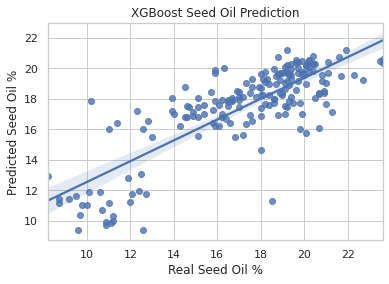

In [22]:
plot_x, plot_y = list(), list()

ho_pheno = ho_pheno.ravel()

for counter, i in enumerate(ho_pheno):
    if counter <= 5:
        print(counter, i, all_preds[counter])
    #zoom in a bit closer
    if(all_preds[counter] > 9):
        plot_x.append(i)
        plot_y.append(all_preds[counter])
    
#plt.plot(plot_x, plot_y, '.')
thisplot = pd.DataFrame({'Oil':plot_x, 'preds':plot_y})
#sns.jointplot(x="Oil", y="preds", data=thisplot, kind='reg' , joint_kws={'scatter_kws': {'alpha': 0.2}})
sns.regplot(x="Oil", y="preds", data=thisplot)
plt.xlabel('Real Seed Oil %')
plt.ylabel('Predicted Seed Oil %')
plt.title("XGBoost Seed Oil Prediction")
plt.show()

In [23]:
pickle.dump(best_model, open("Oil_kfold_10_QTL_XGB.pickle.dat", "wb"))

In [24]:
#only load if not generated in same session
best_model = pickle.load(open("Oil_kfold_10_QTL_XGB.pickle.dat", "rb"))

<Figure size 1440x1440 with 0 Axes>

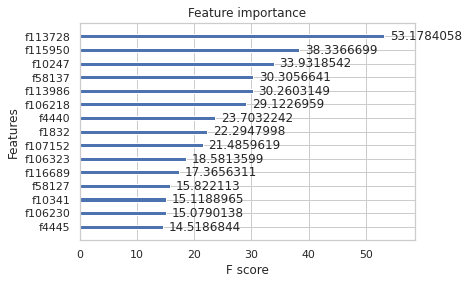

In [25]:
from xgboost import plot_importance
from matplotlib import pyplot
#best_model = pickle.load(open("Oil_kfold_10_tt_from_all.pickle.dat", "rb"))
plt.figure(figsize = (20, 20))
plot_importance(best_model, max_num_features=15, importance_type='gain', height=0.3)
pyplot.show()

In [26]:
#This function essentially returns an array of dataframe headers the length of OHE'd input SNPs for training data
#EG. It will be able to determine that feature 357310 is Gm13_17683957 but not what allele it is
#eg. feature 357309 357310 and 357311 may all be one hot encoded versions of all possible values of Gm13_17683957
#iterating through the saved OHE will by able to determine what specific allele the feature is but cannot determine
#what SNP header it belongs to. Therefore combining these two methods you can determine both allele and SNP
snp = []
imp = SimpleImputer(missing_values='./.', strategy='most_frequent')
fs_ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
x = 0
n_headers = []
le = LabelEncoder()
#while (i < 10):
for chunk in pd.read_csv("Oil_Merged_filtered.csv_train_testQTL_SNPS.csv", chunksize=10000, index_col="Unnamed: 0"):
    chunk = chunk.T
    if 'Value' in chunk.columns:
        print("dropping value so it doesn't include that in headers")
        chunk = chunk.drop(columns=['Value'])
    headers = chunk.columns
    row_idx = chunk.index
    chunk = imp.fit_transform(chunk) #SHOULD TURN ./. into the most common for each column
    #since imputing makes a numpy array have to turn back into PD for label encoding
    chunk = pd.DataFrame(data = chunk, index = row_idx, columns = headers)
    chunk = chunk.apply(lambda col: le.fit_transform(col))
    c_headers = chunk.columns
    y = 0
    for column in chunk:
        d = (chunk[column].nunique())
        n_headers.extend([c_headers[y] for i in range(d)])
        #print(n_headers)
        #print(l)
        #n_headers.append(c_headers[y] * d)
        #print(n_headers)
        y = y + 1
    #to double check that it would indeed be one hot encoded with this amount of columns
    chunk = fs_ohe.fit_transform(chunk)
    x = x + chunk.shape[1]
    print("my X value is: " + str(x))
    print(chunk.shape)
    print("my header list is: " + str(len(n_headers)))
print(len(n_headers))

my X value is: 29287
(753, 29287)
my header list is: 29287
my X value is: 58245
(753, 28958)
my header list is: 58245
my X value is: 87090
(753, 28845)
my header list is: 87090
my X value is: 116223
(753, 29133)
my header list is: 116223
dropping value so it doesn't include that in headers
my X value is: 117552
(753, 1329)
my header list is: 117552
117552


In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(num=None, figsize=(10, 10), dpi=100, facecolor='w', edgecolor='k')
fs = [593927,29855,588433,594046,588431,154384,89664,238306,29856,133635,212368,97360,310115,214640,238315]
scores = [3788.51,3012.53,2338.82,1817.61,1267.10,956.13,721.52,464.87,423.59,387.93,344.70,308.57,249.15,241.69,225.54]
snp_label = []
for jj in fs:
    jj_allele = find_snp_from_header(ohe, jj)
    this_snp = (n_headers[jj] + ' ('+str(jj_allele)+')')
    print(this_snp)
    snp_label.append(this_snp)
snp_label.reverse()
scores.reverse()
print(len(scores))
print(len(snp_label))
plt.barh(snp_label,scores)
plt.title('SNP Importance XGBoost Seed Oil')
plt.ylabel('SNP Label')
plt.xlabel('Relative F_Score (GAIN)')
plt.show()

In [27]:
my_dict = best_model.get_booster().get_score(importance_type="gain")

In [28]:
def rename_f_header(fn,n_headers,ohe):
    fn = fn[1:]
    fn = int(fn)
    allele = find_snp_from_header(ohe, fn)
    this_snp = (n_headers[fn] + ' ('+str(allele)+')')
    return this_snp

In [29]:
#convert feature to actual SNP name
i = 0
new_dict = {}
for key in my_dict:
    new_key = rename_f_header(key, n_headers, ohe)
    new_dict[new_key] = my_dict[key]
    i = i + 1
    print(str(i))
    if(my_dict):
        continue
    else:
        break

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069


In [30]:
new_fi = pd.Series(new_dict)
print(new_fi)
df = new_fi.to_frame()
df = df.rename(columns = {0:'F_Score(GAIN)'})
print(df)

Gm08_46995888 (T/T)    13.909302
Gm08_46545673 (T/T)     6.619141
Gm08_46575132 (G/G)     0.031776
Gm08_48554779 (A/A)    30.305664
Gm01_54734872 (A/A)     0.150647
                         ...    
Gm08_46886706 (T/T)     0.044784
Gm08_48062669 (A/A)     0.316639
Gm08_47420798 (G/A)     0.122710
Gm11_14033155 (A/G)     0.233897
Gm11_15075630 (T/T)     0.065982
Length: 2731, dtype: float64
                     F_Score(GAIN)
Gm08_46995888 (T/T)      13.909302
Gm08_46545673 (T/T)       6.619141
Gm08_46575132 (G/G)       0.031776
Gm08_48554779 (A/A)      30.305664
Gm01_54734872 (A/A)       0.150647
...                            ...
Gm08_46886706 (T/T)       0.044784
Gm08_48062669 (A/A)       0.316639
Gm08_47420798 (G/A)       0.122710
Gm11_14033155 (A/G)       0.233897
Gm11_15075630 (T/T)       0.065982

[2731 rows x 1 columns]


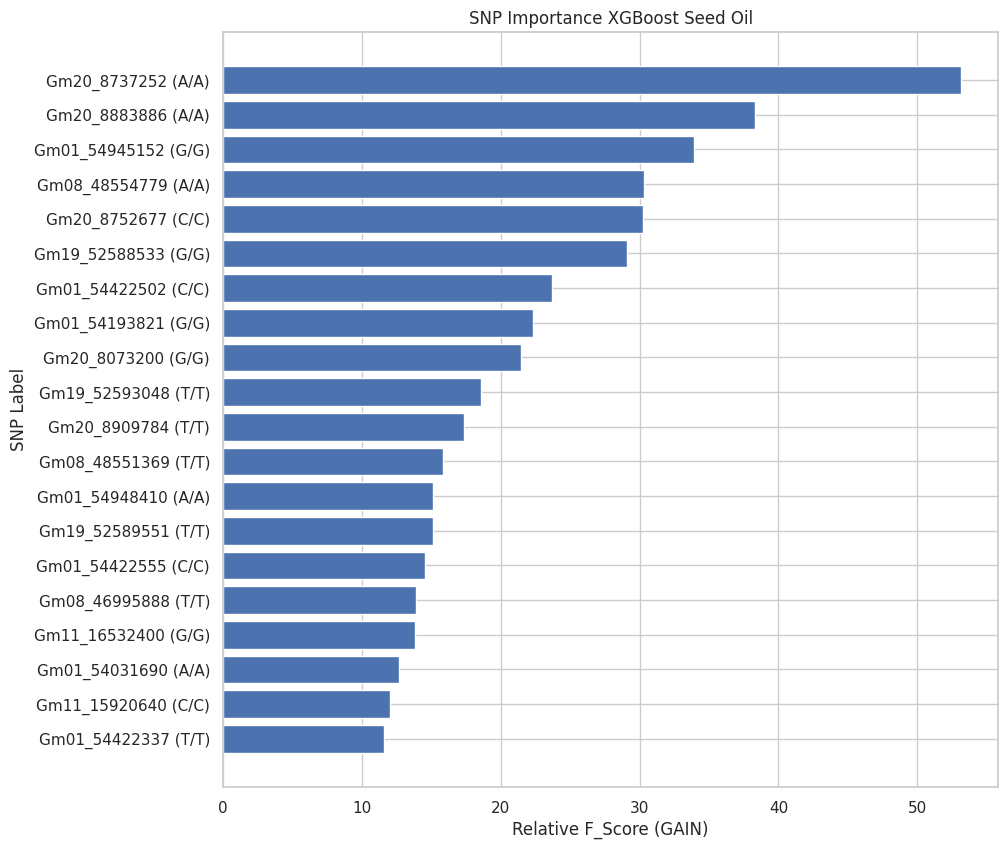

In [31]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(num=None, figsize=(10, 10), dpi=100, facecolor='w', edgecolor='k')
indexes = df.nlargest(20, "F_Score(GAIN)").index
values = df.nlargest(20, "F_Score(GAIN)").values.ravel()
indexes = indexes[::-1]
values = values[::-1]
plt.barh(indexes, values)
plt.title('SNP Importance XGBoost Seed Oil')
plt.ylabel('SNP Label')
plt.xlabel('Relative F_Score (GAIN)')
plt.show()

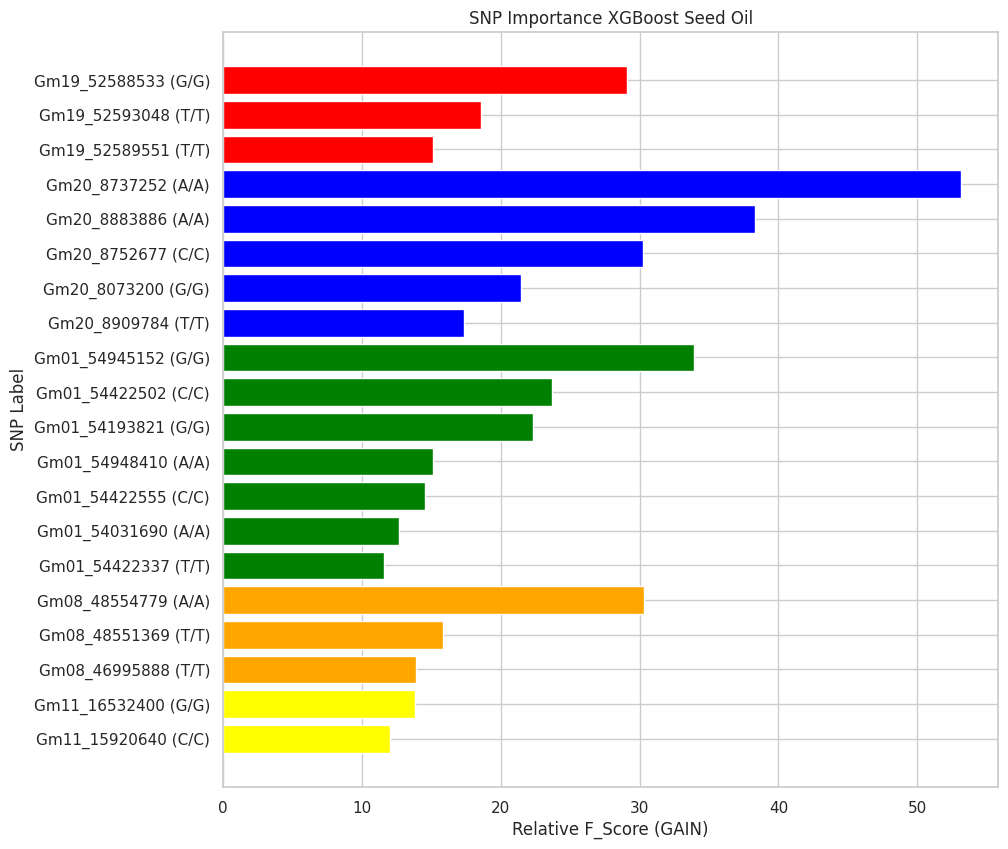

In [32]:
#generate figure object
figure(num=None, figsize=(10, 10), dpi=100, facecolor='w', edgecolor='k')
#load in the 20 lardest values and their SNP label
indexes = df.nlargest(20, "F_Score(GAIN)").index
values = df.nlargest(20, "F_Score(GAIN)").values.ravel()
#reverse to make the largest be at the front
indexes = indexes[::-1]
values = values[::-1]
#for each different chromosome you want to colour add a index(*_i) and value (*_v) array
#black would be colour for singular/notinteresting chromosomes
r_i = []
r_v = []
b_i = []
b_v = []
g_i = []
g_v = []
y_i = []
y_v = []
bl_i = []
bl_v = []
p_i = []
p_v = []
br_i = []
br_v = []
pu_i = []
pu_v = []
#for each value in the top n (default 20) check which chromosome it belongs to and add it to the colour array
i = 0
while i < len(indexes):
    if('Gm19' in indexes[i]):
        r_i.append(indexes[i])
        r_v.append(values[i])
    elif('Gm20' in indexes[i]):
        b_i.append(indexes[i])
        b_v.append(values[i])
    elif('Gm01' in indexes[i]):
        g_i.append(indexes[i])
        g_v.append(values[i])
    elif('Gm11' in indexes[i]):
        y_i.append(indexes[i])
        y_v.append(values[i])
    elif('Gm08' in indexes[i]):
        p_i.append(indexes[i])
        p_v.append(values[i])
   # elif('Gm04' in indexes[i]):
   #     br_i.append(indexes[i])
   #     br_v.append(values[i])
   # elif('Gm13' in indexes[i]):
   #     pu_i.append(indexes[i])
   #     pu_v.append(values[i])
    else:
        bl_i.append(indexes[i])
        bl_v.append(values[i])
    i = i + 1
#plot each of the arrays with appropriate colour and label graph
plt.barh(bl_i, bl_v, color="black")
plt.barh(br_i, br_v, color="brown")
plt.barh(pu_i, pu_v, color="purple")
plt.barh(y_i, y_v, color="yellow")
plt.barh(p_i, p_v, color="orange")
plt.barh(g_i, g_v, color="green")
plt.barh(b_i, b_v, color="blue")
plt.barh(r_i, r_v, color="red")
plt.title('SNP Importance XGBoost Seed Oil')
plt.ylabel('SNP Label')
plt.xlabel('Relative F_Score (GAIN)')
plt.show()

# Random Forest Model

In [33]:
tt_vcf, ho_vcf, tt_pheno, ho_pheno = new_prep_data("Oil_Merged_filtered.csv_train_testQTL_SNPS.csv", "Oil_Merged_filtered.csv_holdoutQTL_SNPS.csv")

10000
20000
30000
40000
(753,)
(753, 1)
50000
10000
20000
30000
40000
(189,)
(189, 1)
50000
(753, 40448)
(189, 40448)


In [34]:
ohe = pickle.load(open("Oil_QTL_ohe.dat", "rb"))
tt_vcf = ohe.transform(tt_vcf)
print(tt_vcf.shape)
print(ho_vcf.shape)
ho_vcf = ohe.transform(ho_vcf)
print(ho_vcf.shape)

(753, 117552)
(189, 40448)
(189, 117552)


In [35]:
model = RandomForestRegressor(n_estimators=100, random_state=16, max_features = 'sqrt',n_jobs=-1, verbose = 1)
#trains the model, and makes the y shape as (m,) instead of (m,1)
#model.fit(X_train, y_train.ravel())

In [36]:
best_rf_model = eval_k_fold(model, tt_vcf, tt_pheno, 10)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 28 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.1s finished
[Parallel(n_jobs=28)]: Using backend ThreadingBackend with 28 concurrent workers.


fitting done. Processing fold accuracy + checking best model


[Parallel(n_jobs=28)]: Done 100 out of 100 | elapsed:    0.1s finished


R^2 Value is: 0.4694350352130494
RMSE for dataset is:1.8182404305198108& mean of this fold is 17.22763
this is 10.55421068125261% of the mean pheno data


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 28 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.1s finished
[Parallel(n_jobs=28)]: Using backend ThreadingBackend with 28 concurrent workers.
[Parallel(n_jobs=28)]: Done 100 out of 100 | elapsed:    0.0s finished


fitting done. Processing fold accuracy + checking best model
R^2 Value is: 0.5056742570147916
RMSE for dataset is:1.6689244101821632& mean of this fold is 18.055264
this is 9.243423162444426% of the mean pheno data


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 28 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.0s finished
[Parallel(n_jobs=28)]: Using backend ThreadingBackend with 28 concurrent workers.
[Parallel(n_jobs=28)]: Done 100 out of 100 | elapsed:    0.0s finished


fitting done. Processing fold accuracy + checking best model
R^2 Value is: 0.6330035045263591
RMSE for dataset is:1.7066442421648593& mean of this fold is 17.325
this is 9.850759982738962% of the mean pheno data


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 28 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.0s finished
[Parallel(n_jobs=28)]: Using backend ThreadingBackend with 28 concurrent workers.
[Parallel(n_jobs=28)]: Done 100 out of 100 | elapsed:    0.0s finished


fitting done. Processing fold accuracy + checking best model
R^2 Value is: 0.6291848924307937
RMSE for dataset is:1.6043737412396308& mean of this fold is 17.337334
this is 9.253866660964755% of the mean pheno data


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 28 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.9s finished
[Parallel(n_jobs=28)]: Using backend ThreadingBackend with 28 concurrent workers.
[Parallel(n_jobs=28)]: Done 100 out of 100 | elapsed:    0.0s finished


fitting done. Processing fold accuracy + checking best model
R^2 Value is: 0.5807334977622112
RMSE for dataset is:1.7845992156457497& mean of this fold is 17.338667
this is 10.292597604547614% of the mean pheno data


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 28 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.0s finished
[Parallel(n_jobs=28)]: Using backend ThreadingBackend with 28 concurrent workers.
[Parallel(n_jobs=28)]: Done 100 out of 100 | elapsed:    0.0s finished


fitting done. Processing fold accuracy + checking best model
R^2 Value is: 0.5123304194543861
RMSE for dataset is:2.0179619039578776& mean of this fold is 17.24
this is 11.70511560759142% of the mean pheno data


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 28 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.0s finished
[Parallel(n_jobs=28)]: Using backend ThreadingBackend with 28 concurrent workers.
[Parallel(n_jobs=28)]: Done 100 out of 100 | elapsed:    0.0s finished


fitting done. Processing fold accuracy + checking best model
R^2 Value is: 0.4928690691488715
RMSE for dataset is:2.0198331211998726& mean of this fold is 17.629333
this is 11.457229064544162% of the mean pheno data


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 28 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.0s finished
[Parallel(n_jobs=28)]: Using backend ThreadingBackend with 28 concurrent workers.
[Parallel(n_jobs=28)]: Done 100 out of 100 | elapsed:    0.0s finished


fitting done. Processing fold accuracy + checking best model
R^2 Value is: 0.7164197476410302
RMSE for dataset is:1.6310393712638187& mean of this fold is 16.917334
this is 9.641231943216598% of the mean pheno data


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 28 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.1s finished
[Parallel(n_jobs=28)]: Using backend ThreadingBackend with 28 concurrent workers.
[Parallel(n_jobs=28)]: Done 100 out of 100 | elapsed:    0.0s finished


fitting done. Processing fold accuracy + checking best model
R^2 Value is: 0.4821301799693909
RMSE for dataset is:1.8102366264721297& mean of this fold is 18.005333
this is 10.053891432183331% of the mean pheno data


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 28 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.0s finished
[Parallel(n_jobs=28)]: Using backend ThreadingBackend with 28 concurrent workers.
[Parallel(n_jobs=28)]: Done 100 out of 100 | elapsed:    0.1s finished


fitting done. Processing fold accuracy + checking best model
R^2 Value is: 0.5345170191081698
RMSE for dataset is:1.9233773964221281& mean of this fold is 17.313332
this is 11.109227504065855% of the mean pheno data
Training Testing Accuracy: 10.32% (0.83%)


In [37]:
all_preds = [x for x in best_rf_model.predict(ho_vcf)]
ss = sqrt(mean_squared_error(all_preds, ho_pheno))
rr = r2_score(all_preds, ho_pheno)
mm = np.mean(ho_pheno)
error_mean = ((ss/mm)*100)
print("R^2 Value of Holdout: %.2f" % rr)
print("RMSE of Holdout: %.2f" % ss)
print("Mean of Holdout: %.2f" % mm)
print("this is "+ str((ss/mm)*100) + "% of the mean pheno data")

R^2 Value of Holdout: 0.45
RMSE of Holdout: 2.06
Mean of Holdout: 17.17
this is 12.02689500724016% of the mean pheno data


[Parallel(n_jobs=28)]: Using backend ThreadingBackend with 28 concurrent workers.
[Parallel(n_jobs=28)]: Done 100 out of 100 | elapsed:    0.0s finished


In [13]:
x_ax = range(len(y_test))
print(x_ax)
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, y_pred, label="predicted") 

plt.title("Test and predicted data")

plt.legend()
plt.show()

i = 0
interval = 65
while(i<len(y_test)):
    i = i + interval
    if(i>len(y_test)):
        my_range = range(i-interval,len(y_test))
    else:
        my_range = range(i-interval,i)
    plt.plot(my_range, y_test[my_range], label="original")
    plt.plot(my_range, y_pred[my_range], label="predicted") 

    plt.title("Test and predicted data")

    plt.legend()
    plt.show()

NameError: name 'y_test' is not defined

# CNN Model (Based upon DL Primer & GMStools)

In [4]:
tt_vcf, ho_vcf, tt_pheno, ho_pheno = new_prep_data('Oil_Merged_filtered.csv_train_testQTL_SNPS.csv', 'Oil_Merged_filtered.csv_holdoutQTL_SNPS.csv')

10000
20000
30000
40000
(753,)
(753, 1)
50000
10000
20000
30000
40000
(189,)
(189, 1)
50000
(753, 40448)
(189, 40448)


In [5]:
ohe = pickle.load(open("Oil_QTL_ohe.dat", "rb"))
tt_vcf = ohe.transform(tt_vcf)
print(tt_vcf.shape)
print(ho_vcf.shape)
ho_vcf = ohe.transform(ho_vcf)
print(ho_vcf.shape)

(753, 117552)
(189, 40448)
(189, 117552)


In [6]:
def build_CNN_model(train_size):    
    #del model
    model = Sequential()
    model.add(Conv1D(filters=12, kernel_size=14, 
                     input_shape=(train_size, 1)))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Conv1D(filters=10, kernel_size=10, 
                     input_shape=(12, 1)))
    model.add(Activation('relu'))
    model.add(Dropout(0.1))
    model.add(Conv1D(filters=8, kernel_size=8, 
                     input_shape=(10, 1)))
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(48, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(1, activation='linear'))
    opt = tf.keras.optimizers.Adamax(learning_rate=0.003)#, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name="Adamax"


    model.compile(loss='mean_squared_error', optimizer=opt, 
                  metrics=[tf.keras.metrics.RootMeanSquaredError()])

    print(model.summary())
    return model

In [7]:
def eval_CNN(x, y, k):
    #model: xgboost model, should be with the best params available
    #x: input data (eg. all samples and SNPS)
    #y: labels
    #k: number of folds for cross validation
    cv = KFold(n_splits=k,shuffle=True)
  #  fig1 = plt.figure(figsize=[12,12])

   # tprs = []
   # aucs = []
    results = []
   # mean_fpr = np.linspace(0,1,100)
    low = 100
    best = []
    i = 1
    for train,test in cv.split(x,y):
        m = build_CNN_model(x.shape[1])
        print("Fold:" + str(i))
        x = x.reshape(x.shape[0], x.shape[1], 1)
        bs = ((x[train].shape[0])/50)
        bs = round(bs)
        m.fit(x[train],y[train].ravel(), validation_data=(x[test], y[test]), epochs=50, batch_size=bs)
        print("fitting done. Processing fold accuracy + checking best model")
        #predictions = [round(value) for value in y_pred]
        #sees how accurate the model was when testing the test set
        all_preds = [x for x in m.predict(x[test])]
        ss = sqrt(mean_squared_error(all_preds, y[test]))
        rr = r2_score(all_preds, y[test])
        mm = np.mean(y[test])
        error_mean = ((ss/mm)*100)
        print("R^2 Value is: " + str(rr))
        print("RMSE for dataset is:" +str(ss) + "& mean of this fold is " + str(mm))
        print("this is "+ str((ss/mm)*100) + "% of the mean pheno data")
        if(error_mean < low):
            low = error_mean
            best = m
        results.append(error_mean)
        i= i+1
        del m
    print("Training Testing Accuracy: %.2f%% (%.2f%%)" % (np.mean(results), np.std(results)))
    return best

In [8]:
#my_model = build_CNN_model()
best_model = eval_CNN(tt_vcf, tt_pheno, 10)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 117539, 12)        180       
_________________________________________________________________
activation (Activation)      (None, 117539, 12)        0         
_________________________________________________________________
dropout (Dropout)            (None, 117539, 12)        0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 117530, 10)        1210      
_________________________________________________________________
activation_1 (Activation)    (None, 117530, 10)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 117530, 10)        0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 117523, 8)         6

Epoch 33/50
677/677 [==============================] - 30s 44ms/sample - loss: 1.5479 - root_mean_squared_error: 1.2442 - val_loss: 10.2396 - val_root_mean_squared_error: 3.1999
Epoch 34/50
677/677 [==============================] - 30s 44ms/sample - loss: 1.5644 - root_mean_squared_error: 1.2508 - val_loss: 5.1023 - val_root_mean_squared_error: 2.2588
Epoch 35/50
677/677 [==============================] - 29s 43ms/sample - loss: 1.8630 - root_mean_squared_error: 1.3649 - val_loss: 5.4585 - val_root_mean_squared_error: 2.3363
Epoch 36/50
677/677 [==============================] - 29s 43ms/sample - loss: 1.5139 - root_mean_squared_error: 1.2304 - val_loss: 4.7184 - val_root_mean_squared_error: 2.1722
Epoch 37/50
677/677 [==============================] - 29s 43ms/sample - loss: 1.7357 - root_mean_squared_error: 1.3174 - val_loss: 4.8805 - val_root_mean_squared_error: 2.2092
Epoch 38/50
677/677 [==============================] - 29s 43ms/sample - loss: 1.5680 - root_mean_squared_error: 1

Train on 677 samples, validate on 76 samples
Epoch 1/50
677/677 [==============================] - 30s 44ms/sample - loss: 298.1812 - root_mean_squared_error: 17.2679 - val_loss: 340.5589 - val_root_mean_squared_error: 18.4542
Epoch 2/50
677/677 [==============================] - 29s 43ms/sample - loss: 262.8933 - root_mean_squared_error: 16.2140 - val_loss: 350.0944 - val_root_mean_squared_error: 18.7108
Epoch 3/50
677/677 [==============================] - 29s 43ms/sample - loss: 214.4159 - root_mean_squared_error: 14.6429 - val_loss: 324.1178 - val_root_mean_squared_error: 18.0033
Epoch 4/50
677/677 [==============================] - 30s 44ms/sample - loss: 157.4741 - root_mean_squared_error: 12.5489 - val_loss: 258.5084 - val_root_mean_squared_error: 16.0782
Epoch 5/50
677/677 [==============================] - 29s 43ms/sample - loss: 100.6307 - root_mean_squared_error: 10.0315 - val_loss: 172.6866 - val_root_mean_squared_error: 13.1410
Epoch 6/50
677/677 [=========================

Epoch 47/50
677/677 [==============================] - 30s 44ms/sample - loss: 0.8212 - root_mean_squared_error: 0.9062 - val_loss: 5.8885 - val_root_mean_squared_error: 2.4266
Epoch 48/50
677/677 [==============================] - 29s 43ms/sample - loss: 1.3497 - root_mean_squared_error: 1.1618 - val_loss: 5.1326 - val_root_mean_squared_error: 2.2655
Epoch 49/50
677/677 [==============================] - 30s 44ms/sample - loss: 1.1593 - root_mean_squared_error: 1.0767 - val_loss: 4.9409 - val_root_mean_squared_error: 2.2228
Epoch 50/50
677/677 [==============================] - 30s 44ms/sample - loss: 1.1684 - root_mean_squared_error: 1.0809 - val_loss: 4.7180 - val_root_mean_squared_error: 2.1721
fitting done. Processing fold accuracy + checking best model
R^2 Value is: 0.6286304270526692
RMSE for dataset is:2.172088393012712& mean of this fold is 17.177633
this is 12.64486414926192% of the mean pheno data
Model: "sequential_3"
________________________________________________________

Epoch 8/50
678/678 [==============================] - 29s 43ms/sample - loss: 7.3938 - root_mean_squared_error: 2.7192 - val_loss: 19.5911 - val_root_mean_squared_error: 4.4262
Epoch 9/50
678/678 [==============================] - 30s 44ms/sample - loss: 3.2414 - root_mean_squared_error: 1.8004 - val_loss: 17.2797 - val_root_mean_squared_error: 4.1569
Epoch 10/50
678/678 [==============================] - 30s 44ms/sample - loss: 2.2351 - root_mean_squared_error: 1.4950 - val_loss: 3.4135 - val_root_mean_squared_error: 1.8476
Epoch 11/50
678/678 [==============================] - 30s 44ms/sample - loss: 2.1320 - root_mean_squared_error: 1.4601 - val_loss: 13.5131 - val_root_mean_squared_error: 3.6760
Epoch 12/50
678/678 [==============================] - 30s 44ms/sample - loss: 1.9840 - root_mean_squared_error: 1.4085 - val_loss: 9.0211 - val_root_mean_squared_error: 3.0035
Epoch 13/50
678/678 [==============================] - 30s 44ms/sample - loss: 1.7193 - root_mean_squared_error: 1

Train on 678 samples, validate on 75 samples
Epoch 1/50
678/678 [==============================] - 30s 45ms/sample - loss: 302.0303 - root_mean_squared_error: 17.3790 - val_loss: 285.1932 - val_root_mean_squared_error: 16.8877
Epoch 2/50
678/678 [==============================] - 29s 43ms/sample - loss: 266.6132 - root_mean_squared_error: 16.3283 - val_loss: 258.3246 - val_root_mean_squared_error: 16.0725
Epoch 3/50
678/678 [==============================] - 30s 44ms/sample - loss: 219.4984 - root_mean_squared_error: 14.8155 - val_loss: 205.5609 - val_root_mean_squared_error: 14.3374
Epoch 4/50
678/678 [==============================] - 29s 43ms/sample - loss: 164.4274 - root_mean_squared_error: 12.8229 - val_loss: 123.3410 - val_root_mean_squared_error: 11.1059
Epoch 5/50
678/678 [==============================] - 29s 43ms/sample - loss: 106.9235 - root_mean_squared_error: 10.3404 - val_loss: 64.7839 - val_root_mean_squared_error: 8.0488
Epoch 6/50
678/678 [===========================

Epoch 47/50
678/678 [==============================] - 30s 44ms/sample - loss: 1.3561 - root_mean_squared_error: 1.1645 - val_loss: 4.3073 - val_root_mean_squared_error: 2.0754
Epoch 48/50
678/678 [==============================] - 29s 43ms/sample - loss: 1.0770 - root_mean_squared_error: 1.0378 - val_loss: 4.4352 - val_root_mean_squared_error: 2.1060
Epoch 49/50
678/678 [==============================] - 30s 44ms/sample - loss: 1.0514 - root_mean_squared_error: 1.0254 - val_loss: 4.9547 - val_root_mean_squared_error: 2.2259
Epoch 50/50
678/678 [==============================] - 30s 44ms/sample - loss: 1.3363 - root_mean_squared_error: 1.1560 - val_loss: 4.1509 - val_root_mean_squared_error: 2.0374
fitting done. Processing fold accuracy + checking best model
R^2 Value is: 0.5734763997796752
RMSE for dataset is:2.037381118395436& mean of this fold is 16.873337
this is 12.074559664821862% of the mean pheno data
Model: "sequential_6"
_______________________________________________________

Epoch 8/50
678/678 [==============================] - 29s 43ms/sample - loss: 7.6020 - root_mean_squared_error: 2.7572 - val_loss: 47.1416 - val_root_mean_squared_error: 6.8660
Epoch 9/50
678/678 [==============================] - 29s 44ms/sample - loss: 3.7886 - root_mean_squared_error: 1.9464 - val_loss: 24.4023 - val_root_mean_squared_error: 4.9399
Epoch 10/50
678/678 [==============================] - 29s 43ms/sample - loss: 3.2974 - root_mean_squared_error: 1.8159 - val_loss: 15.4994 - val_root_mean_squared_error: 3.9369
Epoch 11/50
678/678 [==============================] - 29s 43ms/sample - loss: 3.0190 - root_mean_squared_error: 1.7375 - val_loss: 9.2137 - val_root_mean_squared_error: 3.0354
Epoch 12/50
678/678 [==============================] - 30s 44ms/sample - loss: 2.7162 - root_mean_squared_error: 1.6481 - val_loss: 4.4648 - val_root_mean_squared_error: 2.1130
Epoch 13/50
678/678 [==============================] - 30s 44ms/sample - loss: 2.3315 - root_mean_squared_error: 1

Train on 678 samples, validate on 75 samples
Epoch 1/50
678/678 [==============================] - 30s 45ms/sample - loss: 296.1359 - root_mean_squared_error: 17.2086 - val_loss: 202.6032 - val_root_mean_squared_error: 14.2339
Epoch 2/50
678/678 [==============================] - 29s 43ms/sample - loss: 258.6911 - root_mean_squared_error: 16.0839 - val_loss: 383.2115 - val_root_mean_squared_error: 19.5758
Epoch 3/50
678/678 [==============================] - 29s 43ms/sample - loss: 210.9528 - root_mean_squared_error: 14.5242 - val_loss: 370.8159 - val_root_mean_squared_error: 19.2566
Epoch 4/50
678/678 [==============================] - 29s 43ms/sample - loss: 155.0915 - root_mean_squared_error: 12.4536 - val_loss: 303.4110 - val_root_mean_squared_error: 17.4187
Epoch 5/50
678/678 [==============================] - 29s 43ms/sample - loss: 100.0806 - root_mean_squared_error: 10.0040 - val_loss: 246.1864 - val_root_mean_squared_error: 15.6903
Epoch 6/50
678/678 [=========================

Epoch 47/50
678/678 [==============================] - 29s 43ms/sample - loss: 0.8833 - root_mean_squared_error: 0.9399 - val_loss: 5.2361 - val_root_mean_squared_error: 2.2882
Epoch 48/50
678/678 [==============================] - 29s 43ms/sample - loss: 1.2273 - root_mean_squared_error: 1.1078 - val_loss: 5.3182 - val_root_mean_squared_error: 2.3061
Epoch 49/50
678/678 [==============================] - 30s 44ms/sample - loss: 1.4065 - root_mean_squared_error: 1.1860 - val_loss: 5.4463 - val_root_mean_squared_error: 2.3337
Epoch 50/50
678/678 [==============================] - 29s 43ms/sample - loss: 1.0364 - root_mean_squared_error: 1.0180 - val_loss: 5.3019 - val_root_mean_squared_error: 2.3026
fitting done. Processing fold accuracy + checking best model
R^2 Value is: 0.49799134706151416
RMSE for dataset is:2.302585276661611& mean of this fold is 17.873333
this is 12.882797403185295% of the mean pheno data
Model: "sequential_9"
______________________________________________________

In [10]:
pickle_model=best_model

In [11]:
pickle.dump(pickle_model, open("Oil_kfold_10_CNN_QTL.pickle.dat", "wb"))

TypeError: can't pickle _thread.RLock objects

In [ ]:
best_CNN = pickle.load(open("Oil_kfold_10_CNN_QTL.pickle.dat", "rb"))

In [12]:
ho_vcf = ho_vcf.reshape(ho_vcf.shape[0], ho_vcf.shape[1], 1)
all_preds = [x for x in best_model.predict(ho_vcf)]
ss = sqrt(mean_squared_error(all_preds, ho_pheno))
rr = r2_score(all_preds, ho_pheno)
mm = np.mean(ho_pheno)
error_mean = ((ss/mm)*100)
print("R^2 Value of Holdout: %.2f" % rr)
print("RMSE of Holdout: %.2f" % ss)
print("Mean of Holdout: %.2f" % mm)
print("this is "+ str((ss/mm)*100) + "% of the mean pheno data")

R^2 Value of Holdout: 0.58
RMSE of Holdout: 2.21
Mean of Holdout: 17.17
this is 12.89877223194647% of the mean pheno data


False
False
0 17.6 [15.74025]
1 23.6 [20.457335]
2 15.1 [14.684244]
3 19.2 [18.452417]
4 14.5 [16.745478]
5 14.9 [15.917872]


TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

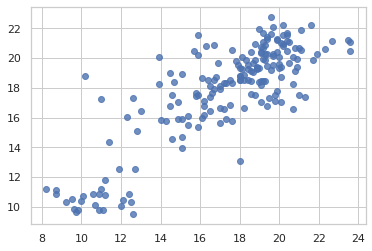

In [14]:
plot_x, plot_y = list(), list()

ho_pheno = ho_pheno.ravel()
print(np.isinf(ho_pheno).any())
print(np.isinf(all_preds).any())
for counter, i in enumerate(ho_pheno):
    if counter <= 5:
        print(counter, i, all_preds[counter])
    #zoom in a bit closer
    if(all_preds[counter] > 9):
        plot_x.append(i)
        plot_y.append(all_preds[counter])
    
#plt.plot(plot_x, plot_y, '.')
thisplot = pd.DataFrame({'Oil':plot_x, 'preds':plot_y})
#sns.jointplot(x="Oil", y="preds", data=thisplot, kind='reg' , joint_kws={'scatter_kws': {'alpha': 0.2}})
sns.regplot(x="Oil", y="preds", data=thisplot)
plt.xlabel('Real Seed Oil %')
plt.ylabel('Predicted Seed Oil %')
plt.title("XGBoost Seed Oil Prediction")
plt.show()

range(0, 189)


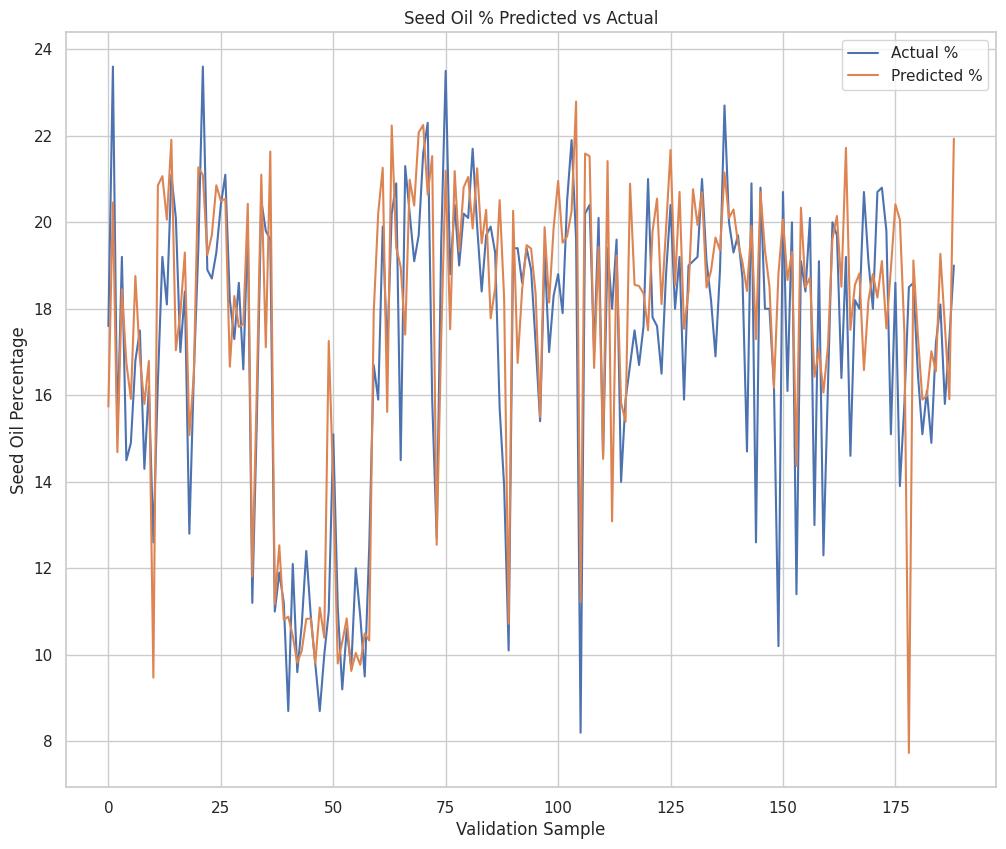

In [15]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(12, 10), dpi=100, facecolor='w', edgecolor='k')
x_ax = range(len(ho_pheno))
print(x_ax)
plt.plot(x_ax, ho_pheno, label="Actual %")
plt.plot(x_ax, all_preds, label="Predicted %") 

plt.title("Seed Oil % Predicted vs Actual")
plt.xlabel('Validation Sample')
plt.ylabel('Seed Oil Percentage')

plt.legend()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

In [ ]:
plt.figure()
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model accuracy')
plt.ylabel('RMSE')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

In [ ]:
all_preds = [x[0] for x in model.predict(X_test)]
sqrt(mean_squared_error(all_preds, y_test))
r2_score(all_preds, y_test)
vcf = vcf.reshape(vcf.shape[0], vcf.shape[1], 1)
d = {'targs': [x for x in pheno], 'preds': [x[0] for x in model.predict(vcf)]}

testdf = pd.DataFrame(data=d)
testdf['minus'] = testdf['targs'] - testdf['preds']

ss = sqrt(mean_squared_error(testdf["preds"], testdf['targs']))
mm = np.mean(pheno)
print("RMSE for dataset is:" +str(ss) + "& pheno is " + str(mm))
print("this is "+ str((ss/mm)*100) + "% of the mean pheno data")

# DNN model
#### Model Based upon: Crop Yield Prediction Using Deep Neural Networks(2019)

In [16]:
tt_vcf, ho_vcf, tt_pheno, ho_pheno = new_prep_data('Oil_Merged_filtered.csv_train_testQTL_SNPS.csv', 'Oil_Merged_filtered.csv_holdoutQTL_SNPS.csv')

10000
20000
30000
40000
(753,)
(753, 1)
50000
10000
20000
30000
40000
(189,)
(189, 1)
50000
(753, 40448)
(189, 40448)


In [17]:
ohe = pickle.load(open("Oil_QTL_ohe.dat", "rb"))
tt_vcf = ohe.transform(tt_vcf)
print(tt_vcf.shape)
print(ho_vcf.shape)
ho_vcf = ohe.transform(ho_vcf)
print(ho_vcf.shape)

(753, 117552)
(189, 40448)
(189, 117552)


In [18]:
#My own DNN model based upon paper
#del model #incase its stored a previous model
#del history #for redoing shit

#do batch size as 64
#reduce the inputs by half when you read it in
#add XGboost and RF to the one notebook
def build_DNN_model(x_len):
    model = Sequential()

    #add first input layer, with no normalization
    model.add(Dense(200, input_dim = x_len))
    model.add(Activation('relu'))
    model.add(Dropout(0.03))
    
    model.add(Dense(100))
    model.add(Activation('relu'))
    model.add(Dropout(0.02))
    
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.01))
    
    model.add(Dense(32))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    
    model.add(Dense(16))
    model.add(Activation('relu'))
    #add output layer
    model.add(Dense(1, activation='linear'))
    opt = tf.keras.optimizers.Adamax(learning_rate=0.003)
    model.compile(loss="mean_squared_error", optimizer=opt, metrics=[tf.keras.metrics.RootMeanSquaredError()])
    print(model.summary())
    return model




In [21]:
def eval_DNN(x, y, k):
    #model: xgboost model, should be with the best params available
    #x: input data (eg. all samples and SNPS)
    #y: labels
    #k: number of folds for cross validation
    cv = KFold(n_splits=k,shuffle=True)
  #  fig1 = plt.figure(figsize=[12,12])

   # tprs = []
   # aucs = []
    results = []
   # mean_fpr = np.linspace(0,1,100)
    low = 100
    best = []
    i = 1
    for train,test in cv.split(x,y):
        m = build_DNN_model(x.shape[1])
        print("Fold:" + str(i))
        bs = ((x[train].shape[0])/50)
        bs = round(bs)
        m.fit(x[train],y[train].ravel(), validation_data=(x[test], y[test]), epochs=100, batch_size=bs)
        print("fitting done. Processing fold accuracy + checking best model")
        #predictions = [round(value) for value in y_pred]
        #sees how accurate the model was when testing the test set
        all_preds = [x for x in m.predict(x[test])]
        ss = sqrt(mean_squared_error(all_preds, y[test]))
        rr = r2_score(all_preds, y[test])
        mm = np.mean(y[test])
        error_mean = ((ss/mm)*100)
        print("R^2 Value is: " + str(rr))
        print("RMSE for dataset is:" +str(ss) + "& mean of this fold is " + str(mm))
        print("this is "+ str((ss/mm)*100) + "% of the mean pheno data")
        if(error_mean < low):
            low = error_mean
            best = m
        results.append(error_mean)
        i= i+1
        del m
    print("Training Testing Accuracy: %.2f%% (%.2f%%)" % (np.mean(results), np.std(results)))
    return best

In [22]:
#my_model = build_CNN_model()
best_DNN = eval_DNN(tt_vcf, tt_pheno, 10)

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_46 (Dense)             (None, 200)               23510600  
_________________________________________________________________
activation_35 (Activation)   (None, 200)               0         
_________________________________________________________________
dropout_23 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_47 (Dense)             (None, 100)               20100     
_________________________________________________________________
activation_36 (Activation)   (None, 100)               0         
_________________________________________________________________
dropout_24 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_48 (Dense)             (None, 64)              

Epoch 34/100
677/677 [==============================] - 1s 2ms/sample - loss: 3.4482 - root_mean_squared_error: 1.8569 - val_loss: 3.0893 - val_root_mean_squared_error: 1.7576
Epoch 35/100
677/677 [==============================] - 1s 2ms/sample - loss: 3.1531 - root_mean_squared_error: 1.7757 - val_loss: 3.7430 - val_root_mean_squared_error: 1.9347
Epoch 36/100
677/677 [==============================] - 1s 2ms/sample - loss: 3.0531 - root_mean_squared_error: 1.7473 - val_loss: 3.6629 - val_root_mean_squared_error: 1.9139
Epoch 37/100
677/677 [==============================] - 1s 2ms/sample - loss: 3.4772 - root_mean_squared_error: 1.8647 - val_loss: 3.4706 - val_root_mean_squared_error: 1.8629
Epoch 38/100
677/677 [==============================] - 1s 2ms/sample - loss: 3.1448 - root_mean_squared_error: 1.7734 - val_loss: 3.6738 - val_root_mean_squared_error: 1.9167
Epoch 39/100
677/677 [==============================] - 1s 2ms/sample - loss: 2.6740 - root_mean_squared_error: 1.6352 -

Epoch 12/100
677/677 [==============================] - 1s 2ms/sample - loss: 6.0803 - root_mean_squared_error: 2.4658 - val_loss: 4.0073 - val_root_mean_squared_error: 2.0018
Epoch 13/100
677/677 [==============================] - 1s 2ms/sample - loss: 6.1043 - root_mean_squared_error: 2.4707 - val_loss: 3.6412 - val_root_mean_squared_error: 1.9082
Epoch 14/100
677/677 [==============================] - 1s 2ms/sample - loss: 5.0765 - root_mean_squared_error: 2.2531 - val_loss: 5.0868 - val_root_mean_squared_error: 2.2554
Epoch 15/100
677/677 [==============================] - 1s 2ms/sample - loss: 5.4431 - root_mean_squared_error: 2.3330 - val_loss: 4.9522 - val_root_mean_squared_error: 2.2254
Epoch 16/100
677/677 [==============================] - 1s 2ms/sample - loss: 5.1194 - root_mean_squared_error: 2.2626 - val_loss: 3.7234 - val_root_mean_squared_error: 1.9296
Epoch 17/100
677/677 [==============================] - 1s 2ms/sample - loss: 5.2410 - root_mean_squared_error: 2.2893 -

Train on 677 samples, validate on 76 samples
Epoch 1/100
677/677 [==============================] - 2s 3ms/sample - loss: 242.9395 - root_mean_squared_error: 15.5865 - val_loss: 62.7430 - val_root_mean_squared_error: 7.9210
Epoch 2/100
677/677 [==============================] - 1s 2ms/sample - loss: 101.8921 - root_mean_squared_error: 10.0942 - val_loss: 32.5443 - val_root_mean_squared_error: 5.7048
Epoch 3/100
677/677 [==============================] - 1s 2ms/sample - loss: 27.1866 - root_mean_squared_error: 5.2141 - val_loss: 32.3378 - val_root_mean_squared_error: 5.6866
Epoch 4/100
677/677 [==============================] - 1s 2ms/sample - loss: 17.6920 - root_mean_squared_error: 4.2062 - val_loss: 18.1251 - val_root_mean_squared_error: 4.2574
Epoch 5/100
677/677 [==============================] - 1s 2ms/sample - loss: 12.5474 - root_mean_squared_error: 3.5422 - val_loss: 8.4807 - val_root_mean_squared_error: 2.9122
Epoch 6/100
677/677 [==============================] - 1s 2ms/sampl

677/677 [==============================] - 1s 2ms/sample - loss: 1.7503 - root_mean_squared_error: 1.3230 - val_loss: 4.9625 - val_root_mean_squared_error: 2.2277
Epoch 94/100
677/677 [==============================] - 1s 2ms/sample - loss: 1.3718 - root_mean_squared_error: 1.1712 - val_loss: 4.5474 - val_root_mean_squared_error: 2.1325
Epoch 95/100
677/677 [==============================] - 1s 2ms/sample - loss: 1.5094 - root_mean_squared_error: 1.2286 - val_loss: 4.6241 - val_root_mean_squared_error: 2.1504
Epoch 96/100
677/677 [==============================] - 1s 2ms/sample - loss: 1.2368 - root_mean_squared_error: 1.1121 - val_loss: 4.6633 - val_root_mean_squared_error: 2.1595
Epoch 97/100
677/677 [==============================] - 1s 2ms/sample - loss: 1.4427 - root_mean_squared_error: 1.2011 - val_loss: 4.3270 - val_root_mean_squared_error: 2.0801
Epoch 98/100
677/677 [==============================] - 1s 2ms/sample - loss: 1.4098 - root_mean_squared_error: 1.1873 - val_loss: 4.

Epoch 25/100
678/678 [==============================] - 1s 2ms/sample - loss: 3.4227 - root_mean_squared_error: 1.8501 - val_loss: 3.9309 - val_root_mean_squared_error: 1.9826
Epoch 26/100
678/678 [==============================] - 1s 2ms/sample - loss: 3.8117 - root_mean_squared_error: 1.9524 - val_loss: 3.7387 - val_root_mean_squared_error: 1.9336
Epoch 27/100
678/678 [==============================] - 1s 2ms/sample - loss: 3.5891 - root_mean_squared_error: 1.8945 - val_loss: 3.7637 - val_root_mean_squared_error: 1.9400
Epoch 28/100
678/678 [==============================] - 1s 2ms/sample - loss: 3.4877 - root_mean_squared_error: 1.8675 - val_loss: 3.8044 - val_root_mean_squared_error: 1.9505
Epoch 29/100
678/678 [==============================] - 1s 2ms/sample - loss: 3.3276 - root_mean_squared_error: 1.8242 - val_loss: 3.8177 - val_root_mean_squared_error: 1.9539
Epoch 30/100
678/678 [==============================] - 1s 2ms/sample - loss: 3.4606 - root_mean_squared_error: 1.8603 -

Epoch 3/100
678/678 [==============================] - 2s 2ms/sample - loss: 28.3364 - root_mean_squared_error: 5.3232 - val_loss: 18.0887 - val_root_mean_squared_error: 4.2531
Epoch 4/100
678/678 [==============================] - 1s 2ms/sample - loss: 19.2799 - root_mean_squared_error: 4.3909 - val_loss: 12.5270 - val_root_mean_squared_error: 3.5393
Epoch 5/100
678/678 [==============================] - 1s 2ms/sample - loss: 15.6064 - root_mean_squared_error: 3.9505 - val_loss: 5.0355 - val_root_mean_squared_error: 2.2440
Epoch 6/100
678/678 [==============================] - 1s 2ms/sample - loss: 15.8201 - root_mean_squared_error: 3.9774 - val_loss: 6.0511 - val_root_mean_squared_error: 2.4599
Epoch 7/100
678/678 [==============================] - 1s 2ms/sample - loss: 17.2374 - root_mean_squared_error: 4.1518 - val_loss: 6.0475 - val_root_mean_squared_error: 2.4592
Epoch 8/100
678/678 [==============================] - 1s 2ms/sample - loss: 13.8398 - root_mean_squared_error: 3.7202

678/678 [==============================] - 1s 2ms/sample - loss: 1.3318 - root_mean_squared_error: 1.1540 - val_loss: 4.0412 - val_root_mean_squared_error: 2.0103
Epoch 96/100
678/678 [==============================] - 1s 2ms/sample - loss: 1.3248 - root_mean_squared_error: 1.1510 - val_loss: 3.9974 - val_root_mean_squared_error: 1.9993
Epoch 97/100
678/678 [==============================] - 1s 2ms/sample - loss: 1.5128 - root_mean_squared_error: 1.2299 - val_loss: 4.5111 - val_root_mean_squared_error: 2.1239
Epoch 98/100
678/678 [==============================] - 1s 2ms/sample - loss: 1.5453 - root_mean_squared_error: 1.2431 - val_loss: 3.9128 - val_root_mean_squared_error: 1.9781
Epoch 99/100
678/678 [==============================] - 1s 2ms/sample - loss: 1.4215 - root_mean_squared_error: 1.1923 - val_loss: 4.1140 - val_root_mean_squared_error: 2.0283
Epoch 100/100
678/678 [==============================] - 1s 2ms/sample - loss: 1.4070 - root_mean_squared_error: 1.1862 - val_loss: 4

Epoch 27/100
678/678 [==============================] - 1s 2ms/sample - loss: 3.9028 - root_mean_squared_error: 1.9755 - val_loss: 4.1032 - val_root_mean_squared_error: 2.0256
Epoch 28/100
678/678 [==============================] - 1s 2ms/sample - loss: 4.2612 - root_mean_squared_error: 2.0643 - val_loss: 3.8931 - val_root_mean_squared_error: 1.9731
Epoch 29/100
678/678 [==============================] - 1s 2ms/sample - loss: 3.5935 - root_mean_squared_error: 1.8957 - val_loss: 3.0518 - val_root_mean_squared_error: 1.7470
Epoch 30/100
678/678 [==============================] - 1s 2ms/sample - loss: 3.5714 - root_mean_squared_error: 1.8898 - val_loss: 2.8647 - val_root_mean_squared_error: 1.6926
Epoch 31/100
678/678 [==============================] - 1s 2ms/sample - loss: 3.7299 - root_mean_squared_error: 1.9313 - val_loss: 2.9540 - val_root_mean_squared_error: 1.7187
Epoch 32/100
678/678 [==============================] - 1s 2ms/sample - loss: 3.7229 - root_mean_squared_error: 1.9295 -

Epoch 5/100
678/678 [==============================] - 1s 2ms/sample - loss: 18.2809 - root_mean_squared_error: 4.2756 - val_loss: 10.8894 - val_root_mean_squared_error: 3.2999
Epoch 6/100
678/678 [==============================] - 1s 2ms/sample - loss: 14.4774 - root_mean_squared_error: 3.8049 - val_loss: 7.3791 - val_root_mean_squared_error: 2.7165
Epoch 7/100
678/678 [==============================] - 1s 2ms/sample - loss: 16.2283 - root_mean_squared_error: 4.0284 - val_loss: 6.4333 - val_root_mean_squared_error: 2.5364
Epoch 8/100
678/678 [==============================] - 1s 2ms/sample - loss: 11.5309 - root_mean_squared_error: 3.3957 - val_loss: 6.4020 - val_root_mean_squared_error: 2.5302
Epoch 9/100
678/678 [==============================] - 1s 2ms/sample - loss: 9.9408 - root_mean_squared_error: 3.1529 - val_loss: 6.9416 - val_root_mean_squared_error: 2.6347
Epoch 10/100
678/678 [==============================] - 1s 2ms/sample - loss: 8.3170 - root_mean_squared_error: 2.8839 -

678/678 [==============================] - 1s 2ms/sample - loss: 1.6013 - root_mean_squared_error: 1.2654 - val_loss: 3.6437 - val_root_mean_squared_error: 1.9089
Epoch 98/100
678/678 [==============================] - 1s 2ms/sample - loss: 1.4274 - root_mean_squared_error: 1.1948 - val_loss: 4.0970 - val_root_mean_squared_error: 2.0241
Epoch 99/100
678/678 [==============================] - 1s 2ms/sample - loss: 1.3187 - root_mean_squared_error: 1.1484 - val_loss: 3.7726 - val_root_mean_squared_error: 1.9423
Epoch 100/100
678/678 [==============================] - 1s 2ms/sample - loss: 0.9858 - root_mean_squared_error: 0.9929 - val_loss: 3.2660 - val_root_mean_squared_error: 1.8072
fitting done. Processing fold accuracy + checking best model
R^2 Value is: 0.6608671451045607
RMSE for dataset is:1.8072171667686092& mean of this fold is 17.876
this is 10.109740558867044% of the mean pheno data
Model: "sequential_18"
_________________________________________________________________
Layer 

Epoch 29/100
678/678 [==============================] - 1s 2ms/sample - loss: 3.6993 - root_mean_squared_error: 1.9234 - val_loss: 3.0428 - val_root_mean_squared_error: 1.7444
Epoch 30/100
678/678 [==============================] - 1s 2ms/sample - loss: 3.9077 - root_mean_squared_error: 1.9768 - val_loss: 3.0841 - val_root_mean_squared_error: 1.7561
Epoch 31/100
678/678 [==============================] - 1s 2ms/sample - loss: 3.5319 - root_mean_squared_error: 1.8793 - val_loss: 3.0509 - val_root_mean_squared_error: 1.7467
Epoch 32/100
678/678 [==============================] - 1s 2ms/sample - loss: 3.5958 - root_mean_squared_error: 1.8962 - val_loss: 3.1583 - val_root_mean_squared_error: 1.7771
Epoch 33/100
678/678 [==============================] - 1s 2ms/sample - loss: 3.5681 - root_mean_squared_error: 1.8889 - val_loss: 2.9820 - val_root_mean_squared_error: 1.7269
Epoch 34/100
678/678 [==============================] - 1s 2ms/sample - loss: 3.4538 - root_mean_squared_error: 1.8584 -

Epoch 7/100
678/678 [==============================] - 1s 2ms/sample - loss: 12.2328 - root_mean_squared_error: 3.4975 - val_loss: 8.5964 - val_root_mean_squared_error: 2.9320
Epoch 8/100
678/678 [==============================] - 1s 2ms/sample - loss: 12.9690 - root_mean_squared_error: 3.6012 - val_loss: 5.5768 - val_root_mean_squared_error: 2.3615
Epoch 9/100
678/678 [==============================] - 1s 2ms/sample - loss: 12.4352 - root_mean_squared_error: 3.5264 - val_loss: 4.5934 - val_root_mean_squared_error: 2.1432
Epoch 10/100
678/678 [==============================] - 1s 2ms/sample - loss: 10.8570 - root_mean_squared_error: 3.2950 - val_loss: 9.2570 - val_root_mean_squared_error: 3.0425
Epoch 11/100
678/678 [==============================] - 1s 2ms/sample - loss: 8.4288 - root_mean_squared_error: 2.9032 - val_loss: 6.7292 - val_root_mean_squared_error: 2.5941
Epoch 12/100
678/678 [==============================] - 1s 2ms/sample - loss: 7.9024 - root_mean_squared_error: 2.8111 

678/678 [==============================] - 1s 2ms/sample - loss: 0.9148 - root_mean_squared_error: 0.9565 - val_loss: 3.5715 - val_root_mean_squared_error: 1.8898
Epoch 100/100
678/678 [==============================] - 1s 2ms/sample - loss: 0.8591 - root_mean_squared_error: 0.9269 - val_loss: 3.4509 - val_root_mean_squared_error: 1.8577
fitting done. Processing fold accuracy + checking best model
R^2 Value is: 0.6565492944709647
RMSE for dataset is:1.8576502774880794& mean of this fold is 17.089334
this is 10.870231832619009% of the mean pheno data
Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_100 (Dense)            (None, 200)               23510600  
_________________________________________________________________
activation_80 (Activation)   (None, 200)               0         
_________________________________________________________________
dropout_50 (Dropout)     

Epoch 31/100
678/678 [==============================] - 1s 2ms/sample - loss: 3.4854 - root_mean_squared_error: 1.8669 - val_loss: 4.7643 - val_root_mean_squared_error: 2.1827
Epoch 32/100
678/678 [==============================] - 1s 2ms/sample - loss: 3.7762 - root_mean_squared_error: 1.9432 - val_loss: 5.0817 - val_root_mean_squared_error: 2.2543
Epoch 33/100
678/678 [==============================] - 1s 2ms/sample - loss: 3.9036 - root_mean_squared_error: 1.9758 - val_loss: 4.6500 - val_root_mean_squared_error: 2.1564
Epoch 34/100
678/678 [==============================] - 1s 2ms/sample - loss: 3.1724 - root_mean_squared_error: 1.7811 - val_loss: 4.6140 - val_root_mean_squared_error: 2.1480
Epoch 35/100
678/678 [==============================] - 1s 2ms/sample - loss: 3.5437 - root_mean_squared_error: 1.8825 - val_loss: 4.4221 - val_root_mean_squared_error: 2.1029
Epoch 36/100
678/678 [==============================] - 1s 2ms/sample - loss: 3.5019 - root_mean_squared_error: 1.8713 -

In [23]:
#ho_vcf = ho_vcf.reshape(ho_vcf.shape[0], ho_vcf.shape[1], 1)
all_preds = [x for x in best_DNN.predict(ho_vcf)]
ss = sqrt(mean_squared_error(all_preds, ho_pheno))
rr = r2_score(all_preds, ho_pheno)
mm = np.mean(ho_pheno)
error_mean = ((ss/mm)*100)
print("R^2 Value of Holdout: %.2f" % rr)
print("RMSE of Holdout: %.2f" % ss)
print("Mean of Holdout: %.2f" % mm)
print("this is "+ str((ss/mm)*100) + "% of the mean pheno data")

R^2 Value of Holdout: 0.51
RMSE of Holdout: 2.31
Mean of Holdout: 17.17
this is 13.450629601977196% of the mean pheno data


0 17.6 [15.522983]
1 23.6 [20.771141]
2 15.1 [14.376863]
3 19.2 [16.067879]
4 14.5 [16.394344]
5 14.9 [15.239873]


TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

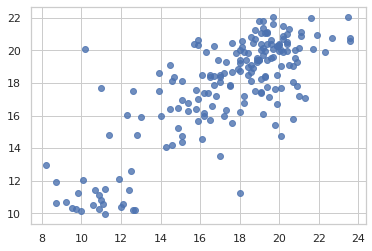

In [24]:
plot_x, plot_y = list(), list()

ho_pheno = ho_pheno.ravel()

for counter, i in enumerate(ho_pheno):
    if counter <= 5:
        print(counter, i, all_preds[counter])
    #zoom in a bit closer
    if(all_preds[counter] > 9):
        plot_x.append(i)
        plot_y.append(all_preds[counter])
    
#plt.plot(plot_x, plot_y, '.')
thisplot = pd.DataFrame({'Oil':plot_x, 'preds':plot_y})
#sns.jointplot(x="Oil", y="preds", data=thisplot, kind='reg' , joint_kws={'scatter_kws': {'alpha': 0.2}})
sns.regplot(x="Oil", y="preds", data=thisplot)
plt.xlabel('Real Seed Oil %')
plt.ylabel('Predicted Seed Oil %')
plt.title("DNN Seed Oil Prediction")
plt.show()

In [ ]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(12, 10), dpi=100, facecolor='w', edgecolor='k')
x_ax = range(len(ho_pheno))
print(x_ax)
plt.plot(x_ax, ho_pheno, label="Actual %")
plt.plot(x_ax, all_preds, label="Predicted %") 

plt.title("Seed Oil % Predicted vs Actual")
plt.xlabel('Validation Sample')
plt.ylabel('Seed Oil Percentage')

plt.legend()
plt.show()

In [ ]:
pickle.dump(best_DNN, open("Oil_kfold_10_DNN.pickle.dat", "wb"))

In [ ]:
best_DNN = pickle.load(open("Oil_kfold_10_DNN.pickle.dat", "rb"))

In [ ]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

In [ ]:
plt.figure()
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model accuracy')
plt.ylabel('RMSE')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

range(0, 189)


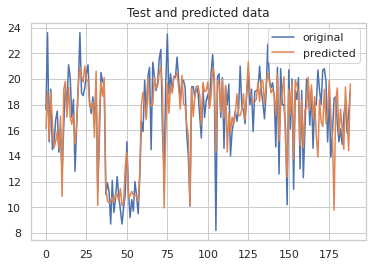

TypeError: list indices must be integers or slices, not range

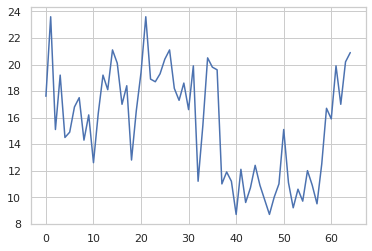

In [10]:
y_test=ho_pheno
x_ax = range(len(y_test))
print(x_ax)
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, all_preds, label="predicted") 

plt.title("Test and predicted data")

plt.legend()
plt.show()

i = 0
interval = 65
while(i<len(y_test)):
    i = i + interval
    if(i>len(y_test)):
        my_range = range(i-interval,len(y_test))
    else:
        my_range = range(i-interval,i)
    plt.plot(my_range, y_test[my_range], label="original")
    plt.plot(my_range, all_preds[my_range], label="predicted") 

    plt.title("Test and predicted data")

    plt.legend()
    plt.show()

In [ ]:
d = {'targs': [x for x in pheno], 'preds': [x[0] for x in model.predict(vcf)]}

testdf = pd.DataFrame(data=d)
testdf['minus'] = testdf['targs'] - testdf['preds']

In [ ]:
ss = sqrt(mean_squared_error(testdf["preds"], testdf['targs']))
mm = np.mean(pheno)
print("RMSE for dataset is:" +str(ss) + "& pheno is " + str(mm))
print("this is "+ str((ss/mm)*100) + "% of the mean pheno data")